# Model Evaluation and Hyperparameter Tuning

## Pipeline: combine transformer and estimator in a pipeline

The make_pipeline function takes an arbitary number of scikit-learn transformers(objects that support the fit and transform methods as input), followed by a scikit-learn estimator that implements the fit and predict method.

    sklearn.pipeline.make_pipeline(*steps, **kwargs)

    *steps: list of estimators.

In [2]:
# Read the breast cancer data
%matplotlib inline
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Encode the class labels
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [5]:
# split test and training set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 1)

In [10]:
# pipeline: standardization + dimensionality reduction + logistic regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components = 2), LogisticRegression(random_state = 1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.942


## Using k-fold cross-validation to assess model performance

1. Holdout cross-validatoin: 
    - seperate the data into three parts: a training set to fit the different models, a validation set for the model selection, and a test set estimate the models' generalization performance.
    - advantage: obtain a less biased estimate of its ability to generalize to new data
    - disadvantage: the performance estimate may be very sensitive to how we partition the training set into the training and validation subsets; the estimate will vary for different samples of the data.
    
2. K-fold cross-validation:
    - randomly split the training dataset into k folds without replacement, where k-1 folds are used for the model training, and one fold is used for performance evaluation. This procedure is repeated k times so that we obtain k models and performance estimates. Then we calculate the average performance of the models that is less sensitive to the sub-partitioning of the training data. Once we found satisfcatory hyperparameter values, we can retrain the model on the complete training set.
    - advantage: a resampling technique without replacement; each sample point will be used for training and validation (as part of a test fold) exactly once, which yields a lower-variance estimate of the model performance thant the holdout method.
    - stratified k-fold cross-validation: unequal class proportions, the class proportions are preserved in each fold;
    
3. Leave-One-Out Cross-Validation (LOOCV): special case of k-fold validaton (k = n)
    

### Choice of k

- small training set, large value of k: lower bias and high variance. 

    - More training data will be used in each iteration, which results in a lower bias towars estimating the generalization performance by averaging the individual model estimates. However, large values of k will also increase the runtime of the cross-validation algorithm and yield estimates with higher variance, since the training folds will be more similar to each other.  
    
- large training set, small value of k 

## Cross-validation in Sklearn

- sklearn.model_selection.KFold(n_splits=5, *, shuffle=False, random_state=None)

- sklearn.model_selection.StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)

    - Parameters:
    
    n_splits: Number of folds. Must be at least 2, default = 5
    
    shuffle: Whether to shuffle each class’s samples before splitting into batches, default = False

- sklearn.model_selection.cross_val_score(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)

    - Parameter:
    
    estimator: estimator object implementing ‘fit’
    
    cv: Determines the cross-validation splitting strategy, default = None (5 folds)

In [17]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

Kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(Kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [225 133], Acc: 0.925
Fold:  2, Class dist.: [225 133], Acc: 0.950
Fold:  3, Class dist.: [225 133], Acc: 0.950
Fold:  4, Class dist.: [225 133], Acc: 0.950
Fold:  5, Class dist.: [225 133], Acc: 0.875
Fold:  6, Class dist.: [225 133], Acc: 1.000
Fold:  7, Class dist.: [225 133], Acc: 0.925
Fold:  8, Class dist.: [225 133], Acc: 0.925
Fold:  9, Class dist.: [225 134], Acc: 0.974
Fold: 10, Class dist.: [225 134], Acc: 0.974

CV accuracy: 0.945 +/- 0.033


In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator = pipe_lr, X = X_train, y = y_train, cv = 10, n_jobs = 1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.925      0.95       0.95       0.95       0.875      1.
 0.925      0.925      0.97435897 0.97435897]
CV accuracy: 0.945 +/- 0.033


## Debugging algorithms with learning and validation curves

- Learning curve: By plotting the model training and validation accuracieis as a functions of the trianing set size, we can detect whether the model suffers from high variance or high bias.
 
    - High bias: low training and cross-validation accuracy, underfitting; increase the nnumber of parameters of the model by collecting or constructing addtional features, or decrease the degree of regularization.
    - High variance: large gap between the training and cross-validation accuracy, overfitting; collect more training data, reduce the complexity of the model, or increase the regularization parameter
    
    
    
- Validation curve: plotting the model accuracies as a funcion of different values of model parameters


### Learning curve in Sklearn

sklearn.model_selection.learning_curve(estimator, X, y, *, groups=None, train_sizes=array([0.1, 0.33, 0.55, 0.78, 1. ]), cv=None, scoring=None, exploit_incremental_learning=False, n_jobs=None, pre_dispatch='all', verbose=0, shuffle=False, random_state=None, error_score=nan, return_times=False)

Parameters:

- estimator: Object type that implements the “fit” and “predict” methods
- train_sizes: Relative or absolute numbers of training examples that will be used to generate the learning curve, default = np.linspace(0.1, 1.0, 5)
- cv: Determines the cross-validation splitting strategy, default = None (5-fold stratifiedKFold)

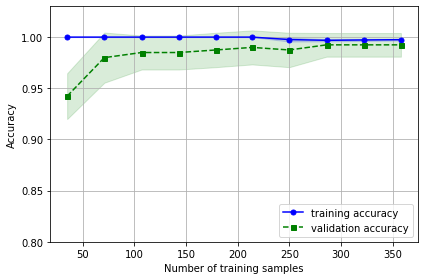

In [36]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l2', random_state = 1))

train_sizes, train_scores, test_scores = learning_curve (estimator = pipe_lr, X = X_train, y = y_train, 
                                                         train_sizes = np.linspace(0.1, 1.0, 10), 
                                                         cv = 10, n_jobs = 1)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'training accuracy')

plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

### Validation curve in Sklearn

sklearn.model_selection.validation_curve(estimator, X, y, *, param_name, param_range, groups=None, cv=None, scoring=None, n_jobs=None, pre_dispatch='all', verbose=0, error_score=nan)

Parameters:
- param_name: Name of the parameter that will be varied.
- param_range：The values of the parameter that will be evaluated.

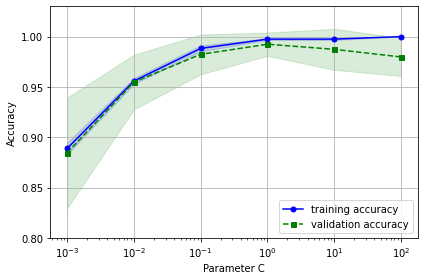

In [40]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator = pipe_lr, X = X_train, y = y_train,
                                            param_name = 'logisticregression__C',
                                            param_range = param_range,
                                            cv = 10)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


## Fine-tuning machine learning models via grid search

- Two types of parameters in machine learning: (1) models learned from the training data, e.g. weights in logistic regression; (2) parameters of a learning algorithm, also called hyperparameters of a model, e.g. regularization parameter, depth of the decision tree.

- Grid search: a brute-force exhaustive search paradim to find the optimal combination of hyperparameter values

### Grid search in Sklearn

sklearn.model_selection.GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)

Parameters:
- param_grid: Dictionary with parameters names (str) as keys and lists of parameter settings to try as values, or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored.
- scoring: Model evaluation rule


Attributes:
- best_estimator_
- best_score_
- best_param_

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state = 1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C':param_range, 'svc__kernel':['linear']},
             {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1) #n_jobs = -1: use all precessors 

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9924358974358973
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [42]:
clf = gs.best_estimator_              # no need to refit the data
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.959


## Algorithm selection with nested cross-validation

- an outer k-fold cross-validation loop to split the data into training and test folds, and an inner loop to select the model using k-fold cross-validation on the training fold

In [45]:
gs = GridSearchCV(estimator = pipe_svc,
                 param_grid = param_grid, scoring = 'accuracy', cv = 2)

scores = cross_val_score(gs, X = X_train, y = y_train, scoring = 'accuracy', cv = 5)

In [46]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0),
                  param_grid = [{'max_depth': [1,2,3,4,5,6,7,None]}],
                  scoring = 'accuracy',
                  cv = 2)

scores = cross_val_score(gs, X = X_train, y = y_train, scoring = 'accuracy', cv = 5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.930 +/- 0.021


 ## Evaluation Metrics
 
 - Confusion matrix: a square matrix that reports the counts of the true positive (TP), True negative (TN), False positive (FP), and False Negative (FN) predictions of a classifier
 
 - Precision and Recall: 
     - Prediction error: 
     
         $ERR = \frac{FP + FN}{FP + FN + TP + TN}$
     - Prediction accuracy: 
     
         $ACC = \frac{TP + TN}{FP + FN + TP + TN}$
     - True Positive Rate: 
     
         $TPR = \frac{TP}{P} = \frac{TP}{TP + FN}$
     - False Positive Rate:
     
         $FPR = \frac{FP}{N} = \frac{FP}{FP + TN}$
     - Precision: 
     
         $PRE = \frac{TP}{TP +FP}$
     - Recall: 
     
         $REC = TPR = \frac{TP}{P} = \frac{TP}{TP + FN}$
     - F1-Score: 
     
         $F1 = 2\frac{PRE * REC}{PRE + REC}$

In [53]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[105   2]
 [  6  58]]


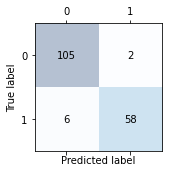

In [49]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.967
Recall: 0.906
F1: 0.935


### Receiver Operating Characteristic (ROC)

- ROC: select models for classification based on their performance with respect to the FPR and TPR, which are computed by shifting the decision threshold of the classifier. 

    - The diagonal of an ROC graph: random guessing
    - Top left corner: a TPR of 1and an FPR of 0
    
- AUC: area undr the curve; performance of a classification model
- Precision-recall curve: different probability thresholds of a classifier

/Users/jingnanbi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/jingnanbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/jingnanbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/jingnanbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


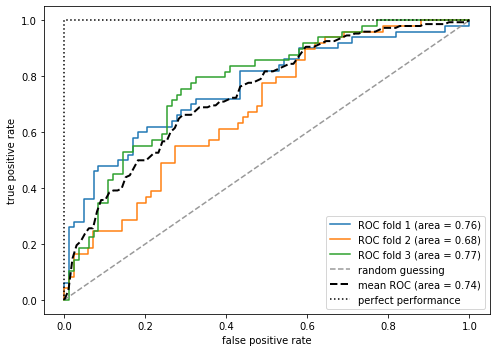

In [52]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components = 2), LogisticRegression(penalty = 'l2', random_state = 1, C = 100.0))

X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits = 3, random_state = 1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

### Scoring metrics for multiclass classification

- Micro-average of precision score:
    - $PRE_{micro} = \frac{TP_1 + ... + TP_k}{TP1 + ... + TP_k + FP_1 + ... + FP_k}$
    - weight each instance or prediction equally

- Macro-average of precision score:
    - $PRE_{macro} = \frac{PRE_1 + ... + PRE_k}{k}$
    - weight all classes equally
    - Weighted macro-average: weight the score of each class label by the number of true instances when calculating the average; useful when dealing with class imbalance
   

In [54]:
from sklearn.metrics import precision_score, make_scorer

pre_score = make_scorer (score_func = precision_score, pos_label = 1, greater_is_better = True, average = 'micro')

## Imbalanced Class

- Choice of evaluation metric: accuracy may not be a good choice
- Learning algorithm:  learns a model that optimizes the predictions based on the most abundant class in the dataset in order to minimize the cost or maximize the reward during training 

    1. assign a larger penalty to wrong predictions on the minority class
    2. upsampling the minority class or downsampling the majority class 
    3. generation of synthetic training samples: Synthetic Minority Oversampling Technique (SMOTE)

In [55]:
# imbalanced data

X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

# predict by majority class
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [60]:
from sklearn.utils import resample

print('Number of class 1 samples before:', X_imb[y_imb == 1].shape[0])

#upsampling minority class
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1], 
                                    replace = True, 
                                    n_samples = X_imb[y_imb ==0].shape[0],
                                    random_state = 123)

print('Number of class 1 samples after:', X_upsampled.shape[0])

Number of class 1 samples before: 40
Number of class 1 samples after: 357


In [59]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0